# Curious Comments 
![commentpic](comment_structure.png)

A critical part of any review are the comments. We will now proceed to analyze the comments in our q data. We will judge the predictive power of these comments, and analyze the role they play in a score's q rating.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import os
import math
from itertools import chain
import ast

The "unit" that we are looking at is the course-semester. In the previous notebook, for each course-semester, we had all comments, all associated Q values, and an attribute 'Positive' which is true if the average Q score for that course for that semester is greater than or equal to the average Q score across all courses for that semester. The 'Positive' attribute is false otherwise. In other words, a course-semester is defined to have an overall positive rating (Positive = True) if its Q score is above the average Q score across all courses for that semester.

We begin by loading in our complete dataframe of comments, which was stored in a csv from the last Python notebook. We will randomly subsample 10 comments per course-semester and only consider course-semesters with 10 or more comments. Our subsampled dataframe will consist of 5 columns: Course, C_Semester, Positive, C_Overall, and Sampled_Comments. 

In [2]:
MIN_PER_COURSESEM_REVIEWS = 10

In [3]:
bigdf=pd.read_csv("bigdf.csv")
bigdf.reset_index(drop=True)
bigdf.head(5)

,C_Department,C_Number,Course,C_CatNum,C_ID,C_Semester,C_Year,C_Term,C_Overall,C_Workload,C_Difficulty,C_Recommendation,C_Enrollment,C_ResponseRate,I_First,I_Last,I_ID,I_Overall,I_EffectiveLectures,I_Accessible,I_GeneratesEnthusiasm,I_EncouragesParticipation,I_UsefulFeedback,I_ReturnsAssignmentsTimely,QOverall_1,QOverall_2,QOverall_3,QOverall_4,QOverall_5,QDifficulty_1,QDifficulty_2,QDifficulty_3,QDifficulty_4,QDifficulty_5,QWorkload_1,QWorkload_2,QWorkload_3,QWorkload_4,QWorkload_5,Comments,Sem_Average,Positive
0,HISTSCI,270,HISTSCI-270,58523,2697,Spring '12,2011,2,4.67,2.33,3.33,5.00,6,50.00,Rebecca,Lemov,79de794d3e2e19eb71a2033b0ec0b76d,4.67,4.33,4.00,4.33,5.00,4.50,4.00,0,0,0,1,2,0,0,2,1,0,0,2,1,0,0,[u'This course is a perfect example of what gr...,4.226350,True
1,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '14,2014,1,4.10,7.10,NaN,3.50,13,76.92,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,4.50,4.60,3.70,3.90,3.90,4.10,4.60,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,"[u'The class has a fairly high work load, but ...",4.244370,False
2,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '13,2013,1,3.50,2.60,3.90,3.20,13,100.00,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,3.80,4.00,2.50,3.50,4.10,4.30,4.40,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,[u'Philosophy of the State with Dr. Chen offer...,4.256888,False
3,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '12,2012,1,3.73,2.47,3.67,3.47,15,100.00,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,3.87,4.33,2.64,3.93,4.18,3.64,3.82,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,[u'This was by far my favorite course. Dr. Che...,4.190299,False
4,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '11,2011,1,3.85,2.00,3.54,3.62,13,100.00,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,4.08,3.75,3.31,3.92,4.46,4.23,4.08,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,"[u'Be prepared to read', u'Discussions were gr...",4.185893,False


We write a helper function sample_comments that takes in a list of comments in string form and then returns one string that contains MIN_PER_COURSEM_REVIEWS randomly selected comments concatenated together.

In [4]:
def sample_comments(commentsListAsString):
    if type(commentsListAsString) != str:
        return ""
    else:
        allComments = ast.literal_eval(commentsListAsString)
        if len(allComments) >= MIN_PER_COURSESEM_REVIEWS:
            return " ".join(np.random.choice(allComments, MIN_PER_COURSESEM_REVIEWS, replace=False))
        else:
            return ""

subdf = bigdf[['Course','C_Semester','Comments', 'Positive', 'C_Overall']].dropna()
subdf["Sampled_Comments"] = subdf.Comments.map(sample_comments)
subdf = subdf[subdf.Sampled_Comments != ""]
subdf['Course_Semester'] = subdf.Course + "-" + subdf.C_Semester
subdf = subdf[['Course','C_Semester','Course_Semester','Positive','C_Overall','Sampled_Comments']]

In [5]:
subdf.head(5)

,Course,C_Semester,Course_Semester,Positive,C_Overall,Sampled_Comments
2,EXPOS-20.132,Fall '13,EXPOS-20.132-Fall '13,False,3.50,Philosophy of the state is a very difficult cl...
3,EXPOS-20.132,Fall '12,EXPOS-20.132-Fall '12,False,3.73,Take this class if you are interested in the c...
13,EXPOS-20.131,Fall '14,EXPOS-20.131-Fall '14,False,3.80,Make sure that you are interested in the mater...
14,EXPOS-20.131,Fall '13,EXPOS-20.131-Fall '13,False,3.60,Be ready for lots of reading! Do not take this...
16,EXPOS-20.131,Fall '11,EXPOS-20.131-Fall '11,True,4.50,Take if you are at all interested in polysci/ ...


Now we will convert our comments dataframe, subdf, to a spark dataframe for text analysis

In [6]:
#setup spark
import os
import findspark
findspark.init()
print findspark.find()
import pyspark
conf = (pyspark.SparkConf()
    .setMaster('local')
    .setAppName('pyspark')
    .set("spark.executor.memory", "2g"))
sc = pyspark.SparkContext(conf=conf)
import sys
rdd = sc.parallelize(xrange(10),10)
rdd.map(lambda x: sys.version).collect()
sys.version
from pyspark.sql import SQLContext
sqlsc=SQLContext(sc)

/usr/local/opt/apache-spark/libexec


In [7]:
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')
from sklearn.feature_extraction import text 
stopwords=text.ENGLISH_STOP_WORDS
import re
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")
#Useless verbs courtesy of: http://mbweston.com/2012/11/26/writing-editing-find-and-eliminate-useless-verbs/
uselessverbs = ['be','is','are','be','was','were','been','being',
                'go','goes','went','gone','going','put','puts','putting',
                'do','does','did','done','doing',
                'come','comes','came','coming',
                'have','have','has','had','having',
                'can','could','begin','begins','began','begun','beginning',
                'seem','seems','seemed','seeming',
                'get','got','gotten','getting',
                'become','became','becoming']
import re
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")

We write a get parts function to parse the language in the comments. This customized get_parts function returns lists of the nouns, adjectives and verbs in the comments.

In [8]:
def get_parts(thetext):
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    nouns=[]
    descriptives=[]
    verbs = []
    for i,sentence in enumerate(parse(thetext, tokenize=True, lemmata=True).split()):
        nouns.append([])
        descriptives.append([])
        verbs.append([])
        for token in sentence:
            #print token
            if len(token[4]) >0:
                if token[1] in ['JJ', 'JJR', 'JJS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    descriptives[i].append(token[4])
                elif token[1] in ['NN', 'NNS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    nouns[i].append(token[4])
                elif token[1] in ['VB','VBP','VBZ','VBG','VBD','VBN']:
                    if token[4] in stopwords or token[4] in uselessverbs or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    verbs[i].append(token[4])
    out=zip(nouns, descriptives,verbs)
    nouns2=[]
    descriptives2=[]
    verbs2 = []
    for n,d,v in out:
        if len(n)!=0 and len(d)!=0 and len(v)!=0:
            nouns2.append(n)
            descriptives2.append(d)
            verbs2.append(v)
    return nouns2, descriptives2, verbs2

In [9]:
subdf = sqlsc.createDataFrame(subdf)
subdf.show(5)

+------------+----------+--------------------+--------+---------+--------------------+
|      Course|C_Semester|     Course_Semester|Positive|C_Overall|    Sampled_Comments|
+------------+----------+--------------------+--------+---------+--------------------+
|EXPOS-20.132|  Fall '13|EXPOS-20.132-Fall...|   false|      3.5|Philosophy of the...|
|EXPOS-20.132|  Fall '12|EXPOS-20.132-Fall...|   false|     3.73|Take this class i...|
|EXPOS-20.131|  Fall '14|EXPOS-20.131-Fall...|   false|      3.8|Make sure that yo...|
|EXPOS-20.131|  Fall '13|EXPOS-20.131-Fall...|   false|      3.6|Be ready for lots...|
|EXPOS-20.131|  Fall '11|EXPOS-20.131-Fall...|    true|      4.5|Take if you are a...|
+------------+----------+--------------------+--------+---------+--------------------+
only showing top 5 rows



We collect the parts of speech (nouns, adjectives, and verbs) for our randomly selected comments.

In [10]:
comment_parts = subdf.rdd.map(lambda r: get_parts(r.Sampled_Comments))
comment_parts.take(1)

[([[u'philosophy', u'state', u'class', u'writing', u'essay', u'college'],
   [u'matter', u'society'],
   [u'philosophy',
    u'stimulating',
    u'class',
    u'discussion',
    u'variety',
    u'topic',
    u'student',
    u'share'],
   [u'philosophy',
    u'state',
    u'discussion',
    u'struggle',
    u'balance',
    u'nature',
    u'society',
    u'course'],
   [u'class'],
   [u'lot', u'philosophy', u'professor', u'lot'],
   [u'course', u'lot', u'reading', u'writing'],
   [u'state', u'philosophy', u'course', u'course', u'student'],
   [u'page',
    u'reading',
    u'day',
    u'syllabus',
    u'warning',
    u'thing',
    u'tardiness',
    u'grade'],
   [u'course'],
   [u'reading', u'understanding', u'work'],
   [u'class', u'lot'],
   [u'class', u'improvement', u'writing', u'understanding', u'writing'],
   [u'deal',
    u'philosophy',
    u'writing',
    u'focus',
    u'philosophy',
    u'writing',
    u'writing',
    u'class'],
   [u'page', u'entirety', u'work'],
   [u'class', u

In [11]:
%%time
parsedcomments=comment_parts.collect()

CPU times: user 145 ms, sys: 22.4 ms, total: 168 ms
Wall time: 1min 19s


We begin our text analysis with an LDA of the nouns in the comments.

The list of lists of nouns for the first course-semester represented in parsedcomments is shown below. Each individual list of nouns represents the nouns of a sentence.

In [12]:
[e[0] for e in parsedcomments[:1]]

[[[u'philosophy', u'state', u'class', u'writing', u'essay', u'college'],
  [u'matter', u'society'],
  [u'philosophy',
   u'stimulating',
   u'class',
   u'discussion',
   u'variety',
   u'topic',
   u'student',
   u'share'],
  [u'philosophy',
   u'state',
   u'discussion',
   u'struggle',
   u'balance',
   u'nature',
   u'society',
   u'course'],
  [u'class'],
  [u'lot', u'philosophy', u'professor', u'lot'],
  [u'course', u'lot', u'reading', u'writing'],
  [u'state', u'philosophy', u'course', u'course', u'student'],
  [u'page',
   u'reading',
   u'day',
   u'syllabus',
   u'warning',
   u'thing',
   u'tardiness',
   u'grade'],
  [u'course'],
  [u'reading', u'understanding', u'work'],
  [u'class', u'lot'],
  [u'class', u'improvement', u'writing', u'understanding', u'writing'],
  [u'deal',
   u'philosophy',
   u'writing',
   u'focus',
   u'philosophy',
   u'writing',
   u'writing',
   u'class'],
  [u'page', u'entirety', u'work'],
  [u'class', u'material', u'experience'],
  [u'class', u'd

We flatten once so that the first five elements of ldadatardd are five sentences.

In [13]:
ldadatardd=sc.parallelize([ele[0] for ele in parsedcomments]).flatMap(lambda l: l)
ldadatardd.cache()
ldadatardd.take(5)

[[u'philosophy', u'state', u'class', u'writing', u'essay', u'college'],
 [u'matter', u'society'],
 [u'philosophy',
  u'stimulating',
  u'class',
  u'discussion',
  u'variety',
  u'topic',
  u'student',
  u'share'],
 [u'philosophy',
  u'state',
  u'discussion',
  u'struggle',
  u'balance',
  u'nature',
  u'society',
  u'course'],
 [u'class']]

We flatten once more so that the first five elements of ldadatardd are five words.

In [14]:
ldadatardd.flatMap(lambda word: word).take(5)

[u'philosophy', u'state', u'class', u'writing', u'essay']

We compile the vocabulary of the comments with and zipWithIndex in anticipation of making the corpus vector later where it will be useful to have a place index.

In [15]:
vocabtups = (ldadatardd.flatMap(lambda word: word)
             .map(lambda word: (word, 1))
             .reduceByKey(lambda a, b: a + b)
             .map(lambda (x,y): x)
             .zipWithIndex()
).cache()

We use the collectAsMap function to create vocab, a dictionary of vocabulary with words as keys and index as values.
In similar fashion, we create id2word, a dictionary with index (id) as keys and vocab as words.

The output below confirms that the relationships between id2word and vocab is correct.

In [16]:
vocab=vocabtups.collectAsMap()
id2word=vocabtups.map(lambda (x,y): (y,x)).collectAsMap()

In [17]:
id2word[0], vocab.keys()[5], vocab[vocab.keys()[5]]

(u'similarity', u'bottino', 6)

We have a unique vocabulary of 4375 words.

In [18]:
len(vocab.keys())

4410

We create documents, a list of tuple lists where each tuplelist represents a sentence. 

The first element of each tuple is the word id and the second element of the tuple is the number of times that the word appears in the sentence.

In [19]:
from collections import defaultdict
def get_wordID_count_tuples(wordList):
    d = defaultdict(int)
    for k in wordList:
        d[vocab[k]] += 1
    return d.items()
documents = ldadatardd.map(lambda w: get_wordID_count_tuples(w))

The below structure for documents appears to be correct.

In [20]:
documents.take(5)

[[(291, 1), (3526, 1), (3274, 1), (1709, 1), (4379, 1), (1663, 1)],
 [(456, 1), (3623, 1)],
 [(1283, 1),
  (3461, 1),
  (3526, 1),
  (3627, 1),
  (4079, 1),
  (2391, 1),
  (1305, 1),
  (4379, 1)],
 [(3526, 1),
  (3623, 1),
  (1360, 1),
  (382, 1),
  (1305, 1),
  (2524, 1),
  (638, 1),
  (1663, 1)],
 [(4379, 1)]]

We store all the documents.

In [21]:
corpus=documents.collect()

We begin our unsupervised LDA topic extraction on the nouns only (instead of verbs or adjectives), since intuitively, the nouns likely reflect the main themes and topics of sentences. We will run the LDA on documents of chunk size 20000 which is hopefully sufficient for the topics to converge. We set the num_topics parameter to 2 because we are looking for to separate our nouns into 2 topics.

In [22]:
import gensim
lda2 = gensim.models.ldamodel.LdaModel(corpus = corpus, num_topics = 2, id2word=id2word, chunksize=20000, passes = 10)

Above, we print the topics we find using LDA.

In [23]:
lda2.print_topics()

[u'0.113*course + 0.026*way + 0.026*student + 0.020*lot + 0.020*problem + 0.019*fun + 0.016*topic + 0.015*language + 0.013*lecture + 0.013*reading',
 u'0.157*class + 0.040*material + 0.035*lot + 0.027*time + 0.026*work + 0.019*lecture + 0.014*professor + 0.014*person + 0.013*paper + 0.012*section']

The first topic (let us call this Topic 0) includes the combination of words: 

- class, lot, time, work, way, professor, problem, section, exam, and fun.


The second topic (let us call this Topic 1) includes the following combination of words: 

- course, material, lecture, student, topic, reading, person, science, year, and lecturer.


Topic 0 seems to encompass the more interactive, qualitative, personable aspects of the course with key terms including class, professor, problem, section, and fun. Topic 1, by contrast, seems to encompass the more solitary, logistical, factual aspects of a course that a student experiences with key terms including material, lecture, student, topic, reading, year, and lecturer. One thing worth noticing is that Topic 1 includes "course" as a key term while Topic 0 includes "class". While "course" and "class" are often used interchangably in language, "class" arguably connotes a more personal, interactive experience than "course", which is more administrative and logistical and more likely to be used as an umbrella term for everything from everyday class to homework. This would support our separation of Topic 0 and 1 into more interactive/personable aspects and more logistical/solitary aspects, respectively.

In order to further evaluate our intial hypothesis that course reviews are split along two topics (interactive, qualitiative, personable aspects v. solitary, logistical aspects), we will output the words of some sentences, along with the probability of the sentence belonging to Topic 0 and Topic 1, to qualitatively check that our topics are reasonable and supported.

In [24]:
for bow in corpus[0:1200:60]:
    print bow
    print lda2.get_document_topics(bow)
    print " ".join([id2word[e[0]] for e in bow])
    print "=========================================="

[(291, 1), (3526, 1), (3274, 1), (1709, 1), (4379, 1), (1663, 1)]
[(0, 0.70179463272623344), (1, 0.29820536727376662)]
writing philosophy essay college class state
[(3721, 1), (3585, 1)]
[(0, 0.18643242579483565), (1, 0.81356757420516435)]
lot material
[(2102, 1), (4079, 1)]
[(0, 0.83158271145038754), (1, 0.16841728854961241)]
level student
[(1305, 1), (2428, 1)]
[(0, 0.16708057207313989), (1, 0.83291942792686013)]
discussion response
[(2856, 1), (1963, 1), (1360, 1), (1752, 1), (1203, 1), (3895, 1), (1080, 1), (4379, 2), (2367, 1)]
[(0, 0.50056276969602442), (1, 0.49943723030397558)]
department world course region teacher requirement classmate class context
[(1360, 1), (2128, 1), (2795, 1), (1221, 1), (1533, 1)]
[(0, 0.90401021056952802), (1, 0.095989789430472053)]
course intro art history way
[(4379, 1), (1030, 1)]
[(0, 0.17102463169320134), (1, 0.82897536830679863)]
class tooth
[(3585, 1), (26, 1), (1700, 1)]
[(0, 0.6672703068557273), (1, 0.33272969314427281)]
material teaching staf

The "sentences" (or bag-of-words) which have a much greater probability of belonging to Topic 0 include:
- class writer load work
- class bit pass work
- class cost intervention u'very benefit reform lot issue
- class student success belief stand risk course question ability
- class kink
- way professor class discussion material
- food professor person class
- class section discussion student
- time homework week

The words in these sentences are more descriptive and relate to more creative, interactive, person-to-person aspects of a course. Specifically, "writer", "intervention", "reform", "issue", "success", "belief", "stand", "risk", "question", "kink", and "discussion" all imply rich and diverse elements of the course experience. As a Harvard student, I know that the word "section" also implies discussion and collaboration since sections for Harvard classes provide an opportunity outside of lecture to engage more closely with course material and consist of tight-knit groups.


The "setences" which have a much greater probability of belonging to Topic 1 include:
- concept background
- reading
- thought-provoking discussion debate material staff teaching

The function below transforms X-col (which consists of word-based "sentences" (bag-of-words or "documents")) using the vectorizer which is also a parameter.
- time bit course u"must
- career course regret
- education perspective lot debate history

Words in these sentences that are not present in the previous cluster of setences and that stand out as implying more impersonal, logistical, or practical aspects of a course include "concept", "background", "reading", "material", "time", "must", "education", "history", and arguably "staff" (since "staff" is a somewhat impersonal way to refer to professors and teaching fellows). Although words like "thought-provoking", "discussion", "debate" and "teaching" do appear, it is worthwhile to note that the sentence/bag-of-words in which they appear still has a relatively high probability of belonging to Topic 0 (~35%).

The "sentences" which have more equal probabilities of belonging to Topic 0 or 1 include:
- time assignment philosophy night
- course lot
- chance education course lot style
- student reason
- way class overview study

For sentences/bag-of-words with relatively equal probabilities of belonging to Topic 0 and Topic 1, we can observe both words implying more interactive, creative aspects ("philosophy", "style", "student", "reason") and words implying more logistical aspects ("time", "assignment", "overview", "study").


From our analysis of the topic probabilities and bag-of-words above, there appears to be evidence to support our initial hypothesis that course reviews are split along two topics: Topic 0, which includes more interactive, qualitative, personable aspects of a course, and Topic 1, which includes more solitary, logistical aspects.

TO DOs:
- We can consider doing "verbs" (use TextBlob)
- Detect "not" before adjectives, this shouldn't be too difficult
- Text before pushing
- Look at differences across departments (Jesse/Andrew)


Let us now continue with a sentiment analysis of the adjectives in the comments using Naive Bayes. We begin by extracting the adjectives as we did before with the nouns. As before, we create adjvocabtups, a list of tuples of with adjectives and index, and we create adjvocab, a dictionary mapping adjectives to the index.

In [25]:
nbdatardd=sc.parallelize([ele[1] for ele in parsedcomments])
nbdatardd.cache()
nbdatardd.take(1)

[[[u'difficult', u'better'],
  [u'subject', u'interesting'],
  [u'wide', u'fellow', u'similar'],
  [u'awesome'],
  [u'difficult', u'accurate'],
  [u'interesting', u'great'],
  [u'critical'],
  [u'passionate'],
  [u'dense', u'occasional', u'terrible'],
  [u'interesting', u'intensive', u'difficult'],
  [u'interesting',
   u'mandatory',
   u'solid',
   u'important',
   u'interesting',
   u'philosophical'],
  [u'great'],
  [u'concrete', u'greater', u'effective'],
  [u'great', u'political', u'different'],
  [u'difficult', u'unnecessary'],
  [u'potential', u'interesting'],
  [u'interesting', u'willing', u'interesting']]]

In [26]:
adjvocabtups = (nbdatardd.flatMap(lambda l: l).flatMap(lambda word: word)
             .map(lambda word: (word, 1))
             .reduceByKey(lambda a, b: a + b)
             .map(lambda (x,y): x)
             .zipWithIndex()
).cache()
adjvocab=adjvocabtups.collectAsMap()

We have 3139 unique adjectives.

In [27]:
len(adjvocab)

3231

Now we will combine all of the adjectives for each course-semester together by flattening all adjectives for each course-semester. We do not care about how adjectives are split up between sentences. We will perform sentiment analysis on one complete list of adjectives per course-semester.

We make an array of these documents to get our adjective "features" and retrieve our response array, comprised of the 'Positive' column of our subdf, as this is the response variable we are trying to predict. The length of Xarray and resparray should be equivalent if we do this correctly.

In [28]:
import itertools
Xarraypre = nbdatardd.map(lambda l: " ".join(list(itertools.chain.from_iterable(l))))
Xarray = Xarraypre.collect()
resparray = subdf.rdd.map(lambda r: r.Positive).collect()

In [29]:
len(Xarray), len(resparray)

(1830, 1830)

All data for semester Fall '14 will be our test set and all data for all other semesters will be contained in our training data. This makes intuitive sense because we are training on "history" (earlier semesters of course data) to predict the "future (the last semester of course data). We create the mask accordingly:

In [30]:
import numpy as np
subdf = subdf.withColumn('Train',subdf.C_Semester != "Fall '14")
mask = np.asarray(subdf.select("Train").rdd.map(lambda r : r.Train).collect());
subdf = subdf.drop('Train')

For convenience, we convert Xarray and Resparray into numpy arrays for use with sklearn.

In [31]:
X=np.array(Xarray)
y=np.array(resparray)

We then transform the adjectives into a bag of words representation and use a vectorizer to create a feature and write some support functions for Naive Bayes analysis. First, we need a helper function that that transforms X_col using vectorizer into a feature matrix with vocabulary as features.

In [32]:
def make_xy(X_col, y_col, vectorizer):
    X = vectorizer.fit_transform(X_col)
    y = y_col
    return X, y

We plan on using log-likelyhood as a scoring metric and write a support function to be able to do so.

In [33]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to 
a Naive Bayes classifier. 
The Log Likelihood is defined by

L = Sum_positive(logP(positive)) + Sum_negative(logP(negative))

Where Sum_positive indicates a sum over all positive reviews, 
and Sum_negative indicates a sum over negative reviews
    
Parameters
----------
clf : Naive Bayes classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Positive
"""
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    negatives = y == False
    positives = ~negatives
    return prob[negatives, False].sum() + prob[positives, True].sum()

We define a function to estimate the cross-validated score (given a classifier, data, and a scoring function).

In [34]:
from sklearn.cross_validation import KFold

def cv_score(clf, x, y, score_func, nfold=5):
    """
    Uses 5-fold cross validation to estimate a score of a classifier
    
    Inputs
    ------
    clf : Classifier object
    x : Input feature vector
    y : Input class labels
    score_func : Function like log_likelihood, that takes (clf, x, y) as input,
                 and returns a score
                 
    Returns
    -------
    The average score obtained by splitting (x, y) into 5 folds of training and 
    test sets, fitting on the training set, and evaluating score_func on the test set
    
    Examples
    cv_score(clf, x, y, log_likelihood)
    """
    result = 0
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf, x[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We also define a useful function for visualizing the calibration of a probabilistic classifier (in order to recognize whether our classifier is over-confident or under-confident).

In [35]:
def calibration_plot(clf, xtest, ytest):
    prob = clf.predict_proba(xtest)[:, 1]
    outcome = ytest
    data = pd.DataFrame(dict(prob=prob, outcome=outcome))

    #group outcomes into bins of similar probability
    bins = np.linspace(0, 1, 20)
    cuts = pd.cut(prob, bins)
    binwidth = bins[1] - bins[0]
    
    #freshness ratio and number of examples in each bin
    cal = data.groupby(cuts).outcome.agg(['mean', 'count'])
    cal['pmid'] = (bins[:-1] + bins[1:]) / 2
    cal['sig'] = np.sqrt(cal.pmid * (1 - cal.pmid) / cal['count'])
        
    #the calibration plot
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    p = plt.errorbar(cal.pmid, cal['mean'], cal['sig'])
    plt.plot(cal.pmid, cal.pmid, linestyle='--', lw=1, color='k')
    plt.ylabel("Empirical P(+)")
    
    #the distribution of P(+)
    ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)
    
    plt.bar(left=cal.pmid - binwidth / 2, height=cal['count'],
            width=.95 * (bins[1] - bins[0]),
            fc=p[0].get_color())
    
    plt.xlabel("Predicted P(+)")
    plt.ylabel("Number")

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

Now we write a cross-validation loop to find the best hyper-parameters for our Naive Bayes analysis.

In [37]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(vocabulary = adjvocab, min_df = min_df)       
        Xthis, ythis = make_xy(X, y, vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        clf = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha, best_min_df = alpha, min_df

/Users/angelama/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: DeprecationWarning: using a boolean instead of an integer will result in an error in the future


In [38]:
print "alpha: %f" % best_alpha
print "min_df: %f" % best_min_df

alpha: 1.000000
min_df: 0.000010


Now that we have determined the best parameters, we are ready to run the Naive Bayes classifier and create a calibration plot. 

Accuracy on training data: 0.85
Accuracy on test data:     0.75


/Users/angelama/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


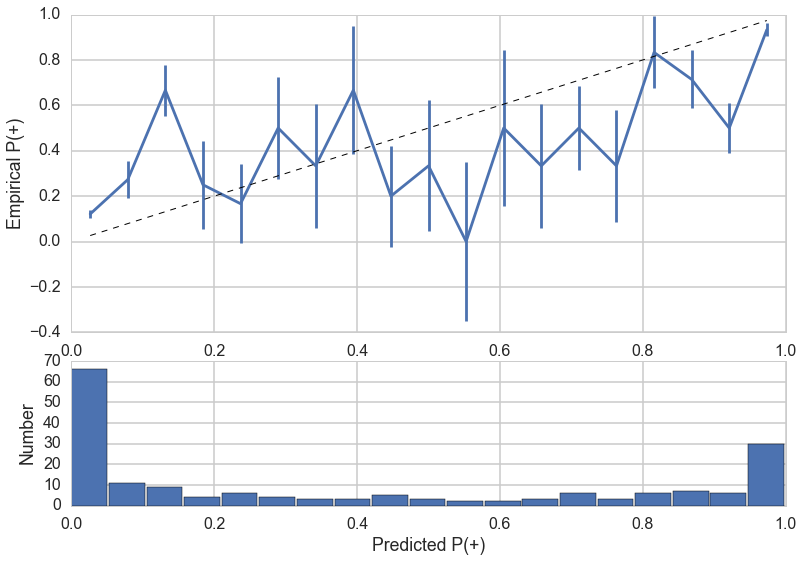

In [39]:
vectorizer = CountVectorizer(vocabulary = adjvocab, min_df=best_min_df)
X2, y2 = make_xy(X, y, vectorizer)
xtrain=X2[mask]
ytrain=y2[mask]
xtest=X2[~mask]
ytest=y2[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

# Your code here. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
calibration_plot(clf, xtest, ytest)

Our model doesn't seem to have a problem with overfitting since the accuracy on the training set is only slightly bigger than the accuracy on the test set (0.85 vs. 0.77, respectively). Note: P(+) is the probability of positive sentiment.

The model is over-confident primarily when making predictions for predicted P(+) lower than approximately 0.2. The model is under-confident when making predictions for most P(+) values higher than 0.4. For positive sentiment predictions made with a confidence of X% where X is less than 20%, our model is correct more X% of the time. For positive sentiment predictions made with a confidence of X% where X is greater than 40, our model is correct less than X% of the time.

The calibration plot shows that the model is generally within 1 error bar of the expected performance (represented by the dotted line) for 0.4 <= P(+) <= 0.7. According to the histogram, the predictions are uniformly clustered for P(+) between 0.2 and 0.9, and have more predictions clustered at the highest and lowest P(+) values. Our model predicts, based on the adjectives, that the probability of positive sentiment is for the most part either very small (close to 0) or very large (close to 1). The clear breakup of predictions into predictions with very low P(+) and very high P(+) suggests that the adjectives in the comments have strong sentiment or that our model is very effective at extracting sentiment from adjectives. Sentiment analysis of adjectives results in either very low or very high predictions of positive sentiment probability. 

The upper half of the calibration plot, however, clearly shows that we have problems with overconfidence with our predictions clustered between Predicted P(+) values of 0 and 0.2, and we have problems with underconfidence for Predicted P(+) values greater than 0.4. Therefore, although the model from verb sentiment analysis gives us strong predictions (many predictions at low predicted P(+) values and few clustered around 0.5), our predictions of low positive sentiment probability are overconfident (correct more often than expected) while our predictions of high positive sentiment probability are underconfident (correct less often than expected). In the upper half of the graph, the blue line does not align well with the dotted line, fluctuating a lot above and below.

In [40]:
nbdatardd_verbs=sc.parallelize([ele[2] for ele in parsedcomments])
nbdatardd_verbs.cache()
nbdatardd_verbs.take(1)

[[[u'make'],
  [u'make', u'think', u'live'],
  [u'offer', u'cover'],
  [u'say', u'enjoy'],
  [u'rumore'],
  [u'learn', u'expect'],
  [u'want', u'learn'],
  [u'attempt', u'terrify'],
  [u'assign', u'offer', u'consist', u'include', u'earn'],
  [u'learn'],
  [u'assign', u'develop'],
  [u'read'],
  [u'assume', u'invest', u'earn'],
  [u'learn', u'feel', u'improve', u'improve', u'improve'],
  [u'work', u'read', u'engage'],
  [u'excite', u'think', u'make', u'disappoint'],
  [u'read', u'frustrate']]]

In [41]:
verbvocabtups = (nbdatardd_verbs.flatMap(lambda l: l).flatMap(lambda word: word)
             .map(lambda word: (word, 1))
             .reduceByKey(lambda a, b: a + b)
             .map(lambda (x,y): x)
             .zipWithIndex()
).cache()
verbvocab=verbvocabtups.collectAsMap()

In [42]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(vocabulary = verbvocab, min_df = min_df)       
        Xthis, ythis = make_xy(X, y, vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        clf = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha, best_min_df = alpha, min_df

/Users/angelama/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: DeprecationWarning: using a boolean instead of an integer will result in an error in the future


In [43]:
print "alpha: %f" % best_alpha
print "min_df: %f" % best_min_df

alpha: 1.000000
min_df: 0.000010


Accuracy on training data: 0.71
Accuracy on test data:     0.67


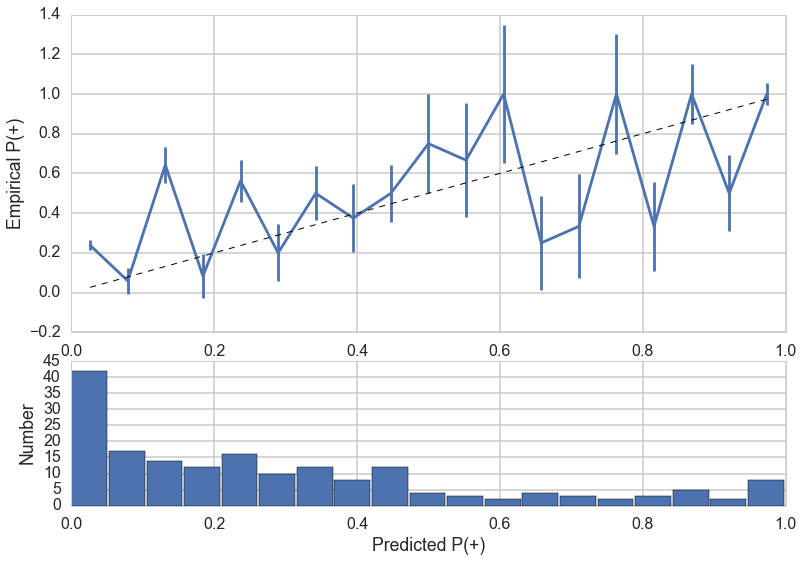

In [44]:
vectorizer = CountVectorizer(vocabulary = verbvocab, min_df=best_min_df)
X2, y2 = make_xy(X, y, vectorizer)
xtrain=X2[mask]
ytrain=y2[mask]
xtest=X2[~mask]
ytest=y2[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

# Your code here. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
calibration_plot(clf, xtest, ytest)

Our model doesn't seem to have a problem with overfitting since the accuracy on the training set is only slightly bigger than the accuracy on the test set (0.71 vs. 0.65, respectively). Note: P(+) is the probability of positive sentiment.

The model is over-confident when making predictions for P(+) lower than approximately 0.6, and the model is under-confident when making predictions for P(+) higher than approximately 0.6. For positive sentiment predictions made with a confidence of X% where X is less than 60%, our model is correct more X% of the time. For positive sentiment predictions made with a confidence of X% where X is greater than 60, our model is correct less than X% of the time.

The calibration plot shows that the model is generally within 1 error bar of the expected performance (represented by the dotted line) for 0.3 <= P(+) <= 0.6. According to the histogram, the predictions are more heavily clustered for P(+) between 0 and 0.2 with less predictions clustered around P(+) values between 0.7 and 1.0. For P(+) vlaues between 0.3 and 0.8, however, our predictions are generally uniformly clustered. There is a trend with more predictions with lower P(+) values. Our model predicts, based on the verbs, that the probability of positive sentiment is likely between 0 and 0.2. In other words, sentiment analysis of the verbs results in low predictions of the probability of positive sentiment. The upper half of the calibration plot, however, clearly shows that we have problems with overconfidence with our predictions clustered between Predicted P(+) values of 0 and 0.2. Therefore, although the model from verb sentiment analysis gives us strong predictions (many predictions at low predicted P(+) values and few clustered around 0.5), our predictions have problems with overconfidence and underconfidence. In the upper half of the graph, the blue line does not align well with the dotted line, fluctuating a lot above and below.

Now we will proceed to combine our LDA with our Naive Bayes analysis for both adjectives and verbs and calculate to get a idea of the extent to which comments can give us idea of whether a course was rated positively or not.

As we have learned from our text analysis that adjectives provide the most useful information in distinguishing positive reviews from negative ones, let us proceed to observe what descriptives are generally found in the q comments of the best rated courses and the worst rated courses to get an idea of what words describe the best and worst courses at Harvard according to q scores. We begin by creating a subdf2, a spark data frame derived from this dataframe that we can use for this type of text analysis.

Now we will proceed to combine our LDA with our Naive Bayes analysis for both adjectives and verbs and calculate to get a idea of the extent to which comments can give us idea of whether a course was rated positively or not. Let us begin by computing the log probabilities for both the adjectives and verbs.

In [ ]:
def log_probs(vocabulary):
    vectorizer2 = CountVectorizer(vocabulary = vocabulary, min_df = 0)
    X3, y3 = make_xy(X, y, vectorizer2)
    clf2 = MultinomialNB(alpha=best_alpha).fit(X3, y3)
    zeroprobs = clf2.feature_log_prob_[0]
    oneprobs = clf2.feature_log_prob_[1]
    allfeatures = vectorizer2.get_feature_names()
    logpositives = {}
    lognegatives = {}
    for i in range(0, len(zeroprobs)):
        lognegatives[allfeatures[i]] = zeroprobs[i]
    for i in range(0, len(oneprobs)):
        logpositives[allfeatures[i]] = oneprobs[i]
    return logpositives, lognegatives

In [46]:
adj_log_positives, adj_log_negatives = log_probs(adjvocab)
verb_log_positives, verb_log_negatives = log_probs(verbvocab)

Next we use Bayes theorum to compute the probability that the comments of a given q review for a semester of a course are positive

We use Bayes theorem for this (+ is the class):

$$P(+\,|\,s) = \frac{P(s\,|\,+)P(+)}{P(s\,|\,+)P(+) + P(s\,|\,-)P(-)}$$

Using the Naive Bayes assumption we find for the adjectives or verbs $\text{word}_i$:

$$P(s\,|\,+) = \prod_i P(\text{word}_i\,|\,+) \implies log(P(s\,|\,+)) = \sum_i log(P(\text{word}_i\,|\,+))$$

Use these two formulae to write a function `calc_pplus` which takes 5 arguments: a list of adjectives `adjlist` constituting a sentence, a dictionary of logpositives `lp`, a dictionary of lognegatives `ln`, the prior probability of a review being positive `pp`, and the prior probability of a review being negative `pn`; and outputs $P(+\,|\,s)$. (The prior probabilities were calculated earlier in this notebook)

In [47]:
Posdf = subdf[subdf['Positive'] == True]
PosNum = Posdf.count()
TotalNum = subdf.count()
Negdf = subdf[subdf['Positive'] == False]
NegNum = Negdf.count()
priorp = float(PosNum) / float(TotalNum)
priorn = float(NegNum) / float(TotalNum)

In [48]:
def calc_pplus(partlist, lp, ln, pp,pn):
    positiveprobs = []
    negativeprobs = []
    for part in partlist:
        positiveprobs.append(lp[part])
        negativeprobs.append(ln[part])
    possum = np.exp(sum(positiveprobs))
    negsum = np.exp(sum(negativeprobs))
    numerator = possum * pp
    denominator = (possum * pp) + (negsum * pn)
    probability = numerator / denominator 
    return probability

We write a function choose_topic which chooses which of the two LDA topics (clusters) we ought to pick for a sentence, given the bag of words for that sentence. This simply uses the higher probability cluster to make a choice. Sometimes get_document_topics only outputs one cluster if the probability is overwhelmingly high. So we need to handle this case.

In [49]:
def choose_topic(ldamodel, bow):
    tee = lda2.get_document_topics(bow)
    if len(tee)==2:
        t1,t2=tee
        if t2[1] >= t1[1]:#get higher probability topic
            topicis=t2[0]
        else:
            topicis=t1[0]
    elif len(tee)==1:#if only one was provided its very high probability. Take it
        teetuple=tee[0]
        topicis=teetuple[0]
    return topicis

We write a function get_positives_dict that combines the functions calc_pplus and choose_topic in a loop below to obtain the sentence topic and calculate the sentiment of the sentence. Note how we use the length of the noun-list for each review from parsedcomments to obtain the appropriate bag-of-words from our corpus. We store our output for each course in a dictionary with keys Course and values a list of dictionaries, one for each sentence with the topic of the sentence and the probability pplus of it "being" or predicting positive. We will run this function for both the adjectives and the verbs. The input of this function once are lognegatives and logpositive dictionaries so that we can specify whether to use the log probabilities for the adjectives or verbs and a boolean adj which will help us to specify whether to use verbs or adjectives from are parsedcomments.

In [50]:
def get_positives_dict(logpositives, lognegatives, adj = True):
    counter=0
    positivesdict={}
    Course_Semesters=subdf.map(lambda r: r.Course_Semester).collect()
    for i, course_sem in enumerate(Course_Semesters):
        course_semlist=[]
        nlist, adjlist, verblist = parsedcomments[i]
        olist = []
        if adj == True:
            olist = adjlist
        else:
            olist = verblist
        ln=len(nlist)
        localbow=corpus[counter:counter+ln]
        for bow, other, noun in zip(localbow, olist, nlist):
            doc=" ".join([id2word[e[0]] for e in bow])
            pplus=calc_pplus(other, logpositives, lognegatives, priorp, priorn)
            topicis=choose_topic(lda2, bow)
            ldict={"topic": topicis, 'pplus':pplus}
            course_semlist.append(ldict)
        positivesdict[course_sem]=course_semlist
        counter=counter+ln
    return positivesdict

In [51]:
%%time 
Adj_pos_dict = get_positives_dict(adj_log_positives, adj_log_negatives,)
Verb_pos_dict = get_positives_dict(verb_log_positives, verb_log_negatives, adj = False)

CPU times: user 13.8 s, sys: 94.3 ms, total: 13.9 s
Wall time: 14.3 s


We begin this process by making two dataframes, Pos_df and Neg_df, which are essentially just dataframes of the positively and negatively rated courses as defined by our criteria that positively rated courses are those that have an overall Q score higher than the average overall Q of the semester in which the rating was given and negatively rated reviews are those with an overall Q score lower than the average overall Q of the semester. Let us sample the top 10% of the positively rated courses to get an idea of the desriptives in the comments of the best q reviews and sample the bottom 10% of the negatively rated courses to get an idea of descriptives in the worst q reviews. To do so, we sort Posdf in descending order and Negdf in ascending order, and then obtain the top and bottom 10%. 

We now write some Spark code to combine this dictionary with the original subdf dataframe to get a dataframe completedf which adds in the individual sentences for each review. The function extendit takes a row and from subdf and a positives_dict , gets the review_id, uses it to lookup the positives_dict above, finds the list of sentence dictionaries there, makes a copy of the dictionaries and augments them with infomation from subdf

In [60]:
def extendit(row, positives_dict):
    outlist=[]
    revs=positives_dict[row.Course_Semester]
    for r in revs:
        r2=r.copy()
        r2['Course']=row.Course
        r2['C_Semester']=row.C_Semester
        r2['Comments']=row.Sampled_Comments
        r2['Positive']=row.Positive
        r2['C_Overall']=row.C_Overall
        r2['Course_Semester'] = row.Course_Semester
        outlist.append(r2)
    return outlist

In [61]:
newdfinadj=subdf.flatMap(lambda r: extendit(r, Adj_pos_dict)).cache()
newdfinverb=subdf.flatMap(lambda r: extendit(r, Verb_pos_dict)).cache()

We use Spark flatMap to create a huge list of dictionaries, one per sentence in the review, and then combine these into a Pandas (not Spark) dataframe completedf and do so for both the Naive Bayes analysis on adjectives and verbs.

In [62]:
completedadjdf=pd.DataFrame(newdfinadj.collect())
completedadjdf.head()

,C_Overall,C_Semester,Comments,Course,Course_Semester,Positive,pplus,topic
0,3.5,Fall '13,Philosophy of the state is a very difficult cl...,EXPOS-20.132,EXPOS-20.132-Fall '13,False,0.300089,0
1,3.5,Fall '13,Philosophy of the state is a very difficult cl...,EXPOS-20.132,EXPOS-20.132-Fall '13,False,0.298194,0
2,3.5,Fall '13,Philosophy of the state is a very difficult cl...,EXPOS-20.132,EXPOS-20.132-Fall '13,False,0.453609,1
3,3.5,Fall '13,Philosophy of the state is a very difficult cl...,EXPOS-20.132,EXPOS-20.132-Fall '13,False,0.552917,0
4,3.5,Fall '13,Philosophy of the state is a very difficult cl...,EXPOS-20.132,EXPOS-20.132-Fall '13,False,0.498586,1


In [63]:
completedverbdf = pd.DataFrame(newdfinverb.collect())
completedverbdf.head()

,C_Overall,C_Semester,Comments,Course,Course_Semester,Positive,pplus,topic
0,3.5,Fall '13,Philosophy of the state is a very difficult cl...,EXPOS-20.132,EXPOS-20.132-Fall '13,False,0.368207,0
1,3.5,Fall '13,Philosophy of the state is a very difficult cl...,EXPOS-20.132,EXPOS-20.132-Fall '13,False,0.863456,0
2,3.5,Fall '13,Philosophy of the state is a very difficult cl...,EXPOS-20.132,EXPOS-20.132-Fall '13,False,0.561157,1
3,3.5,Fall '13,Philosophy of the state is a very difficult cl...,EXPOS-20.132,EXPOS-20.132-Fall '13,False,0.434143,0
4,3.5,Fall '13,Philosophy of the state is a very difficult cl...,EXPOS-20.132,EXPOS-20.132-Fall '13,False,0.487410,1


Now we group by Course_Semester and topic and get the stats for each instance of a course and topic.

In [64]:
def get_stats(group):
    statdict = {}
    statdict['Course']=[group.Course.values[0]]
    statdict['C_Semester']=[group.C_Semester.values[0]]
    statdict['Comments']=[group.Comments.values[0]]
    statdict['C_Overall']=[group.C_Overall.values[0]]
    statdict['Positive']=[group.Positive.values[0]]
    statdict['min_pplus'] = [min(group.pplus.values)]
    statdict['max_pplus'] = [max(group.pplus.values)]
    statdict['count'] = [len(group.index.values)]
    if np.isnan(np.var(group.pplus.values, ddof=1)):
        statdict['var_pplus'] = [0]
    else:
        statdict['var_pplus'] = [np.var(group.pplus.values, ddof=1)]
    statdict['mean_pplus'] = [group.pplus.mean()]
    statdataframe1 = pd.DataFrame.from_dict(statdict)
    statdataframe2 = statdataframe1.reset_index()
    return statdataframe2

In [65]:
adjdftouse=completedadjdf.groupby(['Course_Semester', 'topic']).apply(get_stats).reset_index()
adjdftouse = adjdftouse.set_index('Course_Semester')
adjdftouse.drop("level_2",axis=1,inplace=True)
adjdftouse.drop("index",axis=1,inplace=True)
adjdftouse.head()

/Users/angelama/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


,topic,C_Overall,C_Semester,Comments,Course,Positive,count,max_pplus,mean_pplus,min_pplus,var_pplus
Course_Semester,,,,,,,,,,,
AESTH&INTP-20-Fall '14,0,3.60,Fall '14,Read poems before class to keep your mind fres...,AESTH&INTP-20,False,6,0.826685,0.526911,0.329230,0.038486
AESTH&INTP-20-Fall '14,1,3.60,Fall '14,Read poems before class to keep your mind fres...,AESTH&INTP-20,False,7,0.510253,0.325464,0.192459,0.016167
AESTH&INTP-20-Spring '11,0,4.24,Spring '11,"Do not miss a minute of this class, whether it...",AESTH&INTP-20,True,8,0.761844,0.620436,0.380212,0.016488
AESTH&INTP-20-Spring '11,1,4.24,Spring '11,"Do not miss a minute of this class, whether it...",AESTH&INTP-20,True,4,0.542316,0.446695,0.327378,0.007950
AESTH&INTP-21-Fall '10,0,4.21,Fall '10,Prof Thomas is awesome. If you've always wante...,AESTH&INTP-21,True,6,0.652412,0.500717,0.390590,0.010304


In [66]:
verbdftouse = completedverbdf.groupby(['Course_Semester', 'topic']).apply(get_stats).reset_index()
verbdftouse = verbdftouse.set_index('Course_Semester')
verbdftouse.drop("level_2",axis=1,inplace=True)
verbdftouse.drop("index",axis=1,inplace=True)
verbdftouse.head()

,topic,C_Overall,C_Semester,Comments,Course,Positive,count,max_pplus,mean_pplus,min_pplus,var_pplus
Course_Semester,,,,,,,,,,,
AESTH&INTP-20-Fall '14,0,3.60,Fall '14,Read poems before class to keep your mind fres...,AESTH&INTP-20,False,6,0.837630,0.563694,0.401207,0.026226
AESTH&INTP-20-Fall '14,1,3.60,Fall '14,Read poems before class to keep your mind fres...,AESTH&INTP-20,False,7,0.774733,0.529546,0.354248,0.019451
AESTH&INTP-20-Spring '11,0,4.24,Spring '11,"Do not miss a minute of this class, whether it...",AESTH&INTP-20,True,8,0.634282,0.454646,0.300595,0.014735
AESTH&INTP-20-Spring '11,1,4.24,Spring '11,"Do not miss a minute of this class, whether it...",AESTH&INTP-20,True,4,0.893206,0.543408,0.355999,0.063415
AESTH&INTP-21-Fall '10,0,4.21,Fall '10,Prof Thomas is awesome. If you've always wante...,AESTH&INTP-21,True,6,0.828026,0.446268,0.256369,0.044828


We will proceed to do a few things with these statdfs. We will consider a classifier to be classified as positive if We will observe the true positive rate, false positive rate, false negative rate and true negative rate using the verbs Naive Bayes classifier and the Naive Bayes classifier with adjectives to determine which classifer provides more accurate predictions and whether the verbs or the adjectives of a comment give us more of an idea of whether or not the course is positively rated or negatively rated. We will also test if there is a significant correlation between the mean_pplus and the Q overall to determine if there are significant differences across comments for courses along the whole range of Q scores. We will also observe differences accross topics.
We first create separate dfs for each topic for both adjdftouse and verbdftouse. We then assume a Gaussian distribution of probability means with parameter estimates the review means and variances. Now, using the CDF of the Gaussian like we did in Homework 2, we can calculate the fraction of positive classifications for class 0 and class 1 (Use 0.5 as the threshold). First we define a function prob which takes as arguments a mean and a variance and returns the probability that a sample is positive. We will be using this function later as well. Notice we need to divide the variance by the count num in the formula below to convert from the in-sample variance to the variance of the sample mean. Put another way as compared to the paragraph above, the reason for this is that what we are interested in estimating here is not the average probability of a sentence, for say, topic 0 being positive, but rather the average probability of topic 0 in a review being positive.

In [67]:
c0dfadj=adjdftouse[adjdftouse.topic==0]
c1dfadj=adjdftouse[adjdftouse.topic==1]
c0dfverb=verbdftouse[verbdftouse.topic==0]
c1dfverb=verbdftouse[verbdftouse.topic==1]

In [68]:
from scipy.special import erf
prob= lambda mu, vari, num: .5 * (1 - erf((0.5- mu) / np.sqrt(2 * vari/float(num))))

We then define a function called get_predicteds that concatenates the classifications on to our dfs and calculates the percentage of reviews classified as positive for each topic for the adjectives and the verbs.

In [70]:
def get_predicteds(df0, df1):
    zeroprobs = []
    oneprobs = []
    zeroboolarray = []
    oneboolarray = []
    for index, row in df0.iterrows():
        probability = prob(row['mean_pplus'], row['var_pplus'], row['count'])
        if probability > 0.5:
            zeroboolarray.append(True)
            zeroprobs.append(probability)
        else:
            zeroboolarray.append(False)
    for index, row in df1.iterrows():
        probability = prob(row['mean_pplus'], row['var_pplus'], row['count'])
        if probability > 0.5:
            oneboolarray.append(True)
            oneprobs.append(probability)
        else:
             oneboolarray.append(False)
    df0['Predicted_Positive'] = zeroboolarray
    df1['Predicted_Positive'] = oneboolarray
    estimated_positive_zeroes = float(len(zeroprobs)) / float(df0.shape[0])
    estimated_positive_ones = float(len(oneprobs)) / float(df1.shape[0])
    return df0, df1, estimated_positive_zeroes, estimated_positive_ones

In [74]:
%%time

import warnings
warnings.filterwarnings('ignore')

adjdf0, adjdf1, adj_estimated_positive_zeroes, adj_estimated_positive_ones = get_predicteds(c0dfadj, c1dfadj)
verbdf0, verbdf1, verb_estimated_positive_zeroes, verb_estimated_positive_ones = get_predicteds(c0dfverb, c0dfverb)

CPU times: user 911 ms, sys: 74.9 ms, total: 986 ms
Wall time: 924 ms


In [75]:
adjdf0.head(5)

,topic,C_Overall,C_Semester,Comments,Course,Positive,count,max_pplus,mean_pplus,min_pplus,var_pplus,Predicted_Positive
Course_Semester,,,,,,,,,,,,
AESTH&INTP-20-Fall '14,0,3.60,Fall '14,Read poems before class to keep your mind fres...,AESTH&INTP-20,False,6,0.826685,0.526911,0.329230,0.038486,True
AESTH&INTP-20-Spring '11,0,4.24,Spring '11,"Do not miss a minute of this class, whether it...",AESTH&INTP-20,True,8,0.761844,0.620436,0.380212,0.016488,True
AESTH&INTP-21-Fall '10,0,4.21,Fall '10,Prof Thomas is awesome. If you've always wante...,AESTH&INTP-21,True,6,0.652412,0.500717,0.390590,0.010304,True
AESTH&INTP-21-Spring '12,0,3.75,Spring '12,"This is a wonderful course, one of the best ge...",AESTH&INTP-21,False,7,0.761329,0.471950,0.151718,0.049505,False
AESTH&INTP-21-Spring '13,0,4.31,Spring '13,This is an amazing course. The required texts ...,AESTH&INTP-21,True,8,0.561483,0.456585,0.409483,0.002929,False


In [76]:
def get_rates(df):
    tpcount = 0.0
    fpcount = 0.0
    fncount = 0.0
    tncount = 0.0
    for index, row in df.iterrows():
        if row['Positive'] == row['Predicted_Positive']:
            if row['Positive'] == True:
                tpcount = tpcount + 1
            else:
                tncount = tncount + 1
        else:
            if row['Positive'] == True:
                fncount = fncount + 1
            else:
                fpcount = fpcount + 1
    zerototal = float(df.shape[0])
    tprate = tpcount / zerototal * 100
    fprate = fpcount / zerototal * 100
    fnrate = fncount / zerototal * 100
    tnrate = tncount / zerototal * 100
    ratesdict = {}
    ratesdict['tprate'] = tprate
    ratesdict['fprate'] = fprate
    ratesdict['fnrate'] = fnrate
    ratesdict['tnrate'] = tnrate
    return ratesdict

In [77]:
zeroadjrates = get_rates(adjdf0)
oneadjrates = get_rates(adjdf1)
zeroverbrates = get_rates(verbdf0)
oneverbrates = get_rates(verbdf1)

Now let us plot a bar chart of these results to get an better idea of the accuracy and implications of our verb and adjective classifiers. First we combine the dictionaries for verbs and adjectives into a single df to make plotting easier

In [78]:
def get_concat_df(dict1, dict2):
    finaldict = {}
    finaldict['True_Positive_Rate'] = [dict1['tprate'], dict2['tprate']]
    finaldict['True_Negative_Rate'] = [dict1['tnrate'], dict2['tnrate']]
    finaldict['False_Positive_Rate'] = [dict1['fprate'], dict2['fprate']]
    finaldict['False_Negative_Rate'] = [dict1['fnrate'], dict2['fnrate']]
    finaldf = pd.DataFrame.from_dict(finaldict)
    return finaldf

In [79]:
finaldfadj = get_concat_df(zeroadjrates, oneadjrates)
finaldfverbs = get_concat_df(zeroverbrates, oneverbrates)
finaldfadj.head()

,False_Negative_Rate,False_Positive_Rate,True_Negative_Rate,True_Positive_Rate
0,22.928177,1.988950,56.79558,18.287293
1,23.623348,1.762115,56.88326,17.731278


(0, 100)

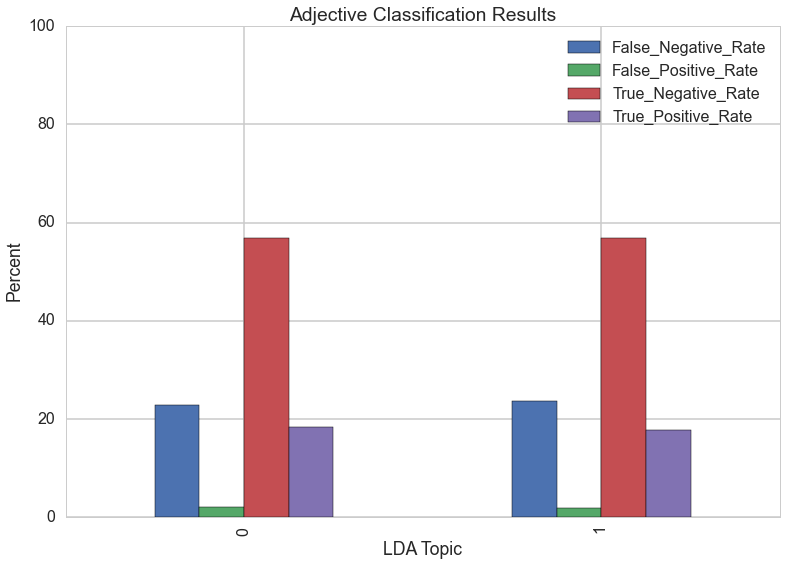

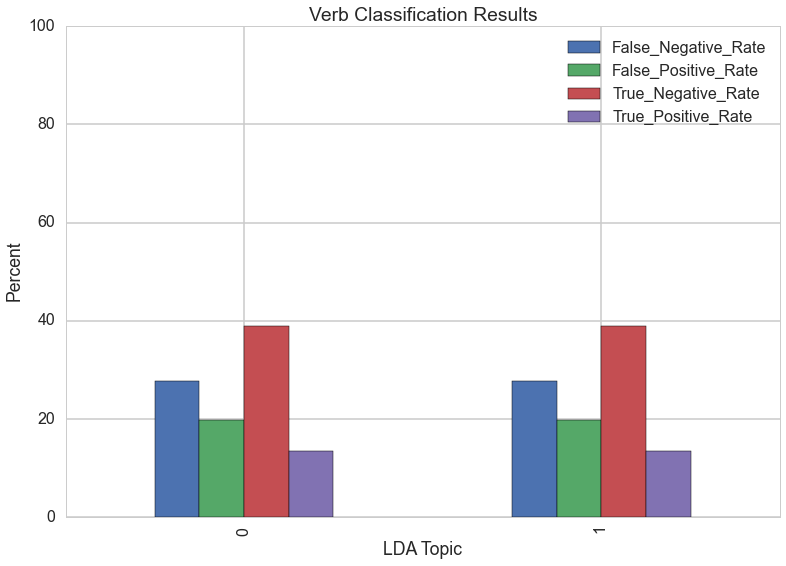

In [80]:
finaldfadj.plot(kind='bar')
plt.legend(frameon = False, loc='best')
plt.title("Adjective Classification Results")
plt.xlabel("LDA Topic")
plt.ylabel("Percent")
plt.ylim(0,100)
finaldfverbs.plot(kind ='bar')
plt.title("Verb Classification Results")
plt.xlabel("LDA Topic")
plt.ylabel("Percent")
plt.legend(frameon = False, loc='best')
plt.ylim(0,100)

ADJECTIVES:

Our results using adjectives from both topics have very high true negative rates and very low (almost 0) false positive rates, which suggests that our model is extremely successful at predicting/recognizing negative sentiment from analysis of adjectives. Our true positive and false negative rates are approximately equivalent using adjectives sentiment analysis, which suggests that our model is not very effective (has approximately 50% accuracy) at estimating positive sentiment using adjectives.

VERBS:

The verbs from both topics have very high true negative rate, relatively high false negative rates, and relatively lower false positive and true positive rates. The true positive rate is lowest of all rates for verbs of both topics. The true negative and false positive rates refer to comments that are actually negative while the true positive and false negative rates refer to comments that are actually positive. The high true negative and false positive rates mean that a majority of verbs have negative sentiment, which is in agreement with our calibration plots above which indicated a clustering of predictions near low (close to 0) P(+) values. The true negative rate (red bar) is significantly higher than our false positive rate (blue bar) which indicates that our model is effective at recognizing negative sentiment. Ideally, the blue bar should be as close to 0 as possible (no false positives), but the significant discrepancy between the true negative and false positives rates indicate that our model is effective to a degree at predicting sentiment using verb sentiment analysis. Our model is less effective at predicting positive sentiment using verbs as we can see that the false negative rate is greater than the true positive rate.

(0, 100)

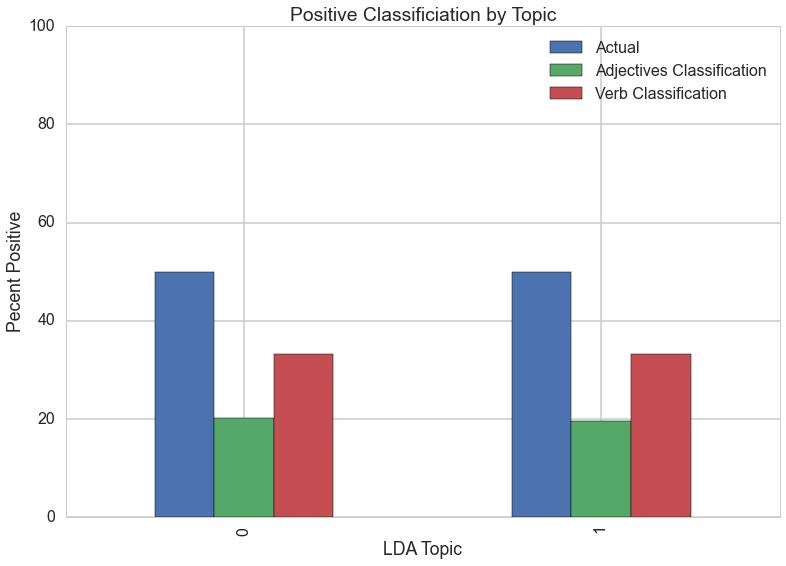

In [81]:
positivesdictfinal = {}
positivesdictfinal['Adjectives Classification'] = [adj_estimated_positive_zeroes * 100, adj_estimated_positive_ones * 100]
positivesdictfinal['Verb Classification'] = [verb_estimated_positive_zeroes  * 100, verb_estimated_positive_ones * 100]
positivesdictfinal['Actual'] = [50, 50]
positivesdf = pd.DataFrame.from_dict(positivesdictfinal)
positivesdf.plot(kind='bar')
plt.legend(frameon = False, loc='best')
plt.title("Positive Classificiation by Topic")
plt.xlabel("LDA Topic")
plt.ylabel("Pecent Positive")
plt.ylim(0,100)

As we have learned from our text analysis that adjectives provide the most useful information in distinguishing positive reviews from negative ones, let us proceed to observe what descriptives are generally found in the q comments of the best rated courses and the worst rated courses to get an idea of what words describe the best and worst courses at Harvard according to q scores. We begin by creating a subdf2, a spark data frame derived from this dataframe that we can use for this type of text analysis.
We begin this process by making two dataframes, Pos_df and Neg_df, which are essentially just dataframes of the positively and negatively rated courses as defined by our criteria that positively rated courses are those that have an overall Q score higher than the average overall Q of the semester in which the rating was given and negatively rated reviews are those with an overall Q score lower than the average overall Q of the semester. Let us sample the top 10% of the positively rated courses to get an idea of the desriptives in the comments of the best q reviews and sample the bottom 10% of the negatively rated courses to get an idea of descriptives in the worst q reviews. To do so, we sort Posdf in descending order and Negdf in ascending order, and then obtain the top and bottom 10%.

In [82]:
Posdf = subdf[subdf['Positive'] == True]
PosNum = Posdf.count()
Top10 = int(0.1 * PosNum)
Posdf = Posdf.rdd.sortBy(lambda x: x.C_Overall, ascending = False)
Posdf = sqlsc.createDataFrame(Posdf.take(Top10))
Negdf = subdf[subdf['Positive'] == False]
NegNum = Negdf.count()
Bottom10 = int(0.1 * NegNum)
Negdf = Negdf.rdd.sortBy(lambda x: x.C_Overall)
Negdf = sqlsc.createDataFrame(Negdf.take(Bottom10))

Now we extract the adjectives in the positive and negative reviews. 

In [83]:
%%time
Positive_comment_parts = Posdf.rdd.map(lambda r: get_parts(r.Sampled_Comments)).collect()
Negative_comment_parts = Negdf.rdd.map(lambda r: get_parts(r.Sampled_Comments)).collect()

CPU times: user 96.3 ms, sys: 107 ms, total: 204 ms
Wall time: 11.6 s


Let us take a look at the sample of the adjectives in the negatively rated courses and positively rated courses.

get_top is a helper function that takes in the part of speech (N, A, V), negative comment parts, positive comment parts, number of word to show, and other specifications to create a Wordle Visualization of the specified number of top positive and top negative words.

In [84]:
from pytagcloud import create_tag_image, make_tags
from pytagcloud.lang.counter import get_tag_counts
from IPython.display import Image

def get_top(part_of_speech,neg_comment_parts,pos_comment_parts, num_words_to_show, maxsize=120,negImgSize = (1200,1000),posImgSize=(1200,1000),background=(0, 0, 0, 0)):
    if part_of_speech == 'N' or part_of_speech == 0 :
        i = 0
    elif part_of_speech == 'A' or part_of_speech == 1:
        i = 1
    elif part_of_speech == 'V' or part_of_speech == 2:
        i = 2
    else:
        i = -1
    negativerdd = sc.parallelize([ele[i] for ele in neg_comment_parts])
    positiverdd = sc.parallelize([ele[i] for ele in pos_comment_parts])

    top_neg = (negativerdd.flatMap(lambda l: l).flatMap(lambda word: word)
               .map(lambda w: (w, 1))
               .reduceByKey(lambda x, y: x + y)
               .collect())
    sorted_neg = sorted(top_neg, key=lambda tup: tup[1], reverse=True)
    
    top_pos = (positiverdd.flatMap(lambda l: l).flatMap(lambda word: word)
               .map(lambda w: (w, 1))
               .reduceByKey(lambda x, y: x + y)
               .collect())
    sorted_pos = sorted(top_pos, key=lambda tup: tup[1], reverse=True)

    neg_tags = make_tags(sorted_neg[:num_words_to_show], maxsize=maxsize)
    create_tag_image(neg_tags, 'Top_20_Negative_%s.png'%part_of_speech, size=negImgSize, fontname='Lobster',background=(0, 0, 0, 0))
    pos_tags = make_tags(sorted_pos[:num_words_to_show], maxsize=maxsize)
    create_tag_image(pos_tags, 'Top_20_Positive_%s.png'%part_of_speech, size=posImgSize, fontname='Lobster',background=(0, 0, 0, 0))
    return negativerdd, sorted_neg, neg_tags, positiverdd, sorted_pos, 

Let us now retrieve the top 20 descriptives for the negatively rated and positively rated reviews using some flattening and a spark word count algorithm. We can also create wordle visualizations to help us better observe the distinctions between the descriptives of positively and negatively rated words.

In [85]:
get_top('N',Negative_comment_parts,Positive_comment_parts, num_words_to_show=40, maxsize=120,negImgSize = (1200,1000),posImgSize=(1200,1000));
get_top('A',Negative_comment_parts,Positive_comment_parts, num_words_to_show=40, maxsize=120,negImgSize = (1400,1000),posImgSize=(1200,1000));
get_top('V',Negative_comment_parts,Positive_comment_parts, num_words_to_show=40, maxsize=120,negImgSize = (1200,1000),posImgSize=(1200,1000));

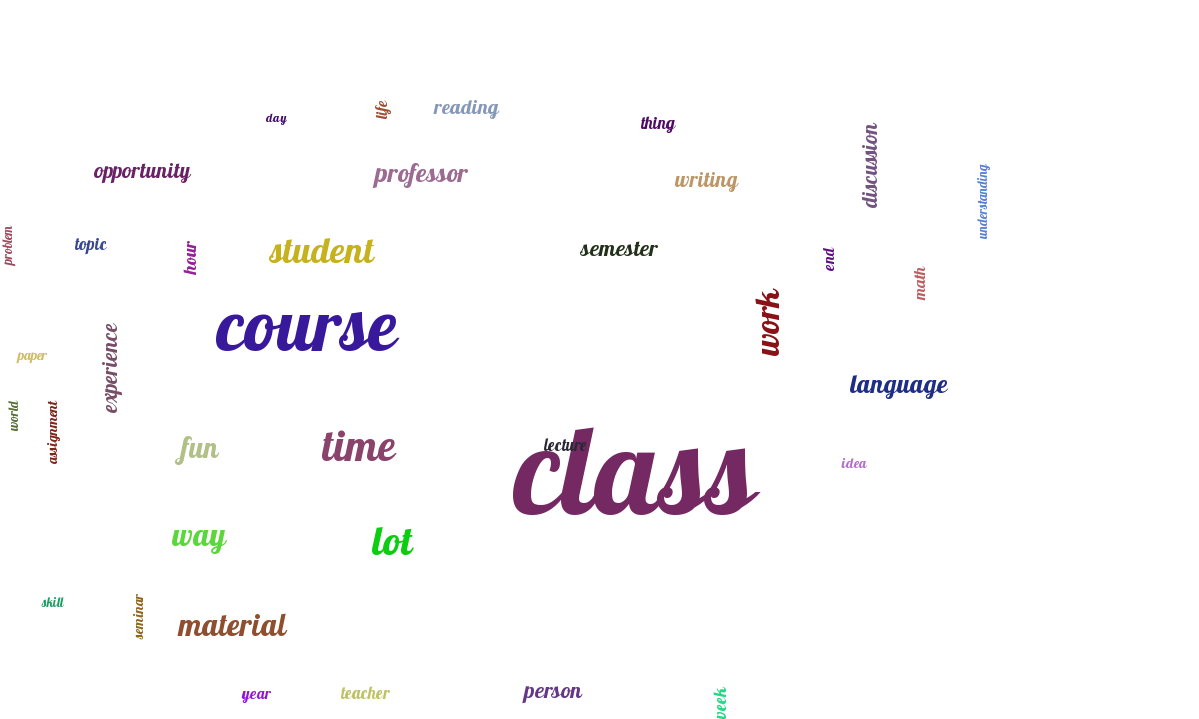

In [86]:
from IPython.display import Image
Image(filename='Top_20_Positive_N.png')

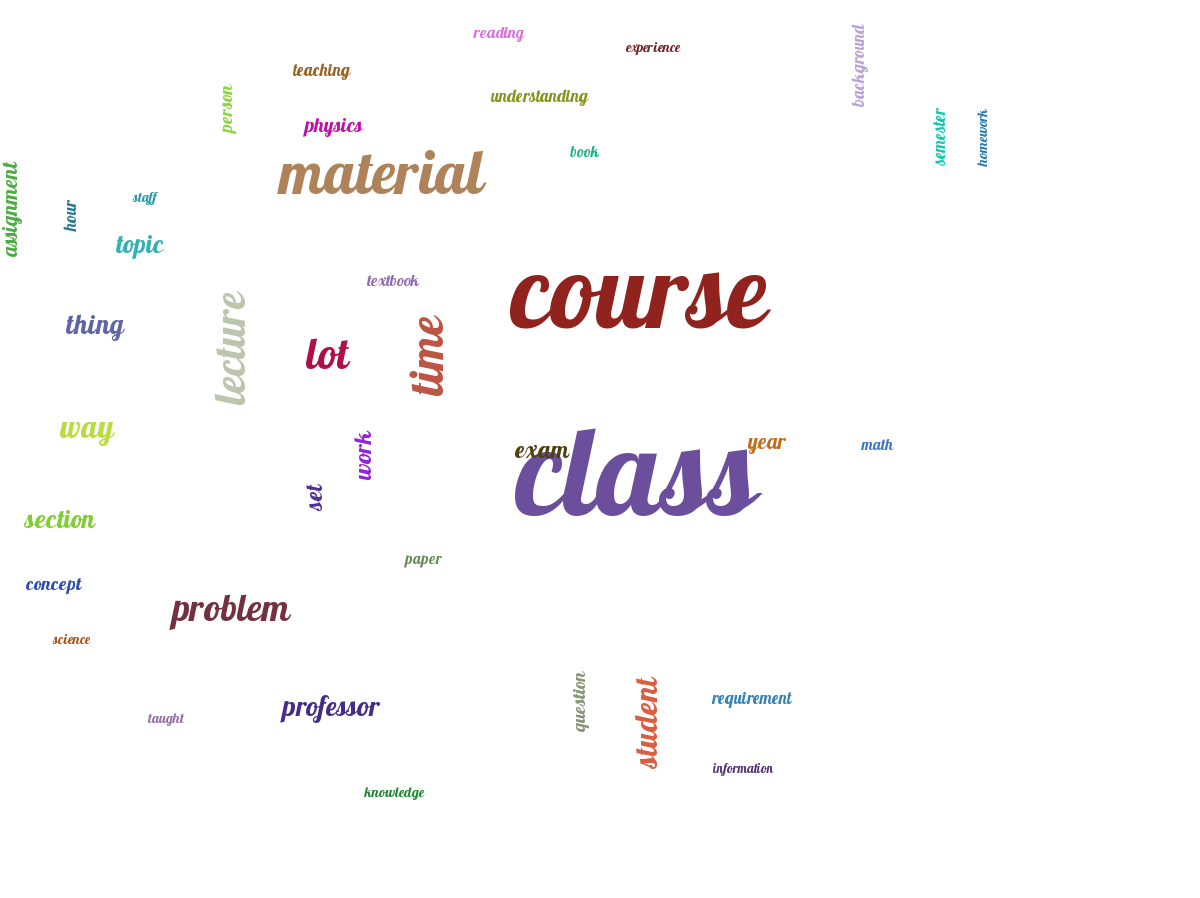

In [87]:
Image(filename='Top_20_Negative_N.png')

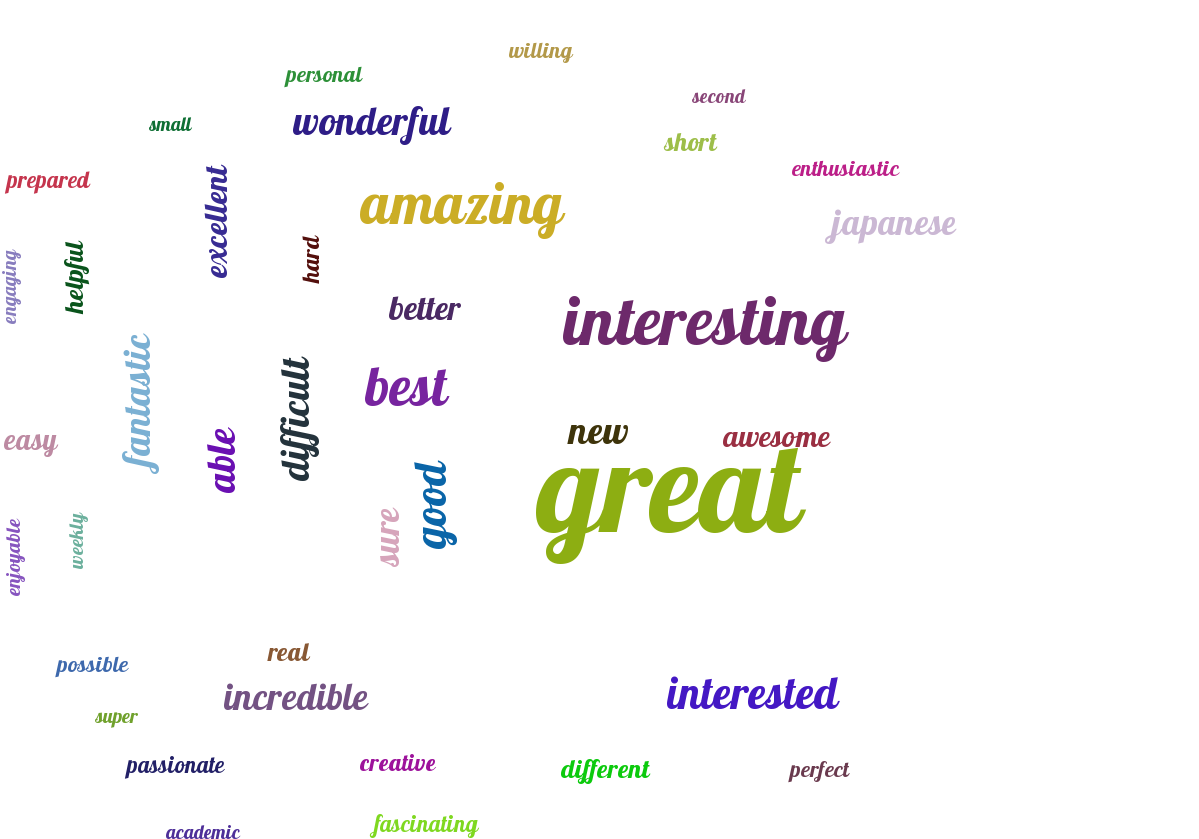

In [88]:
Image(filename='Top_20_Positive_A.png')

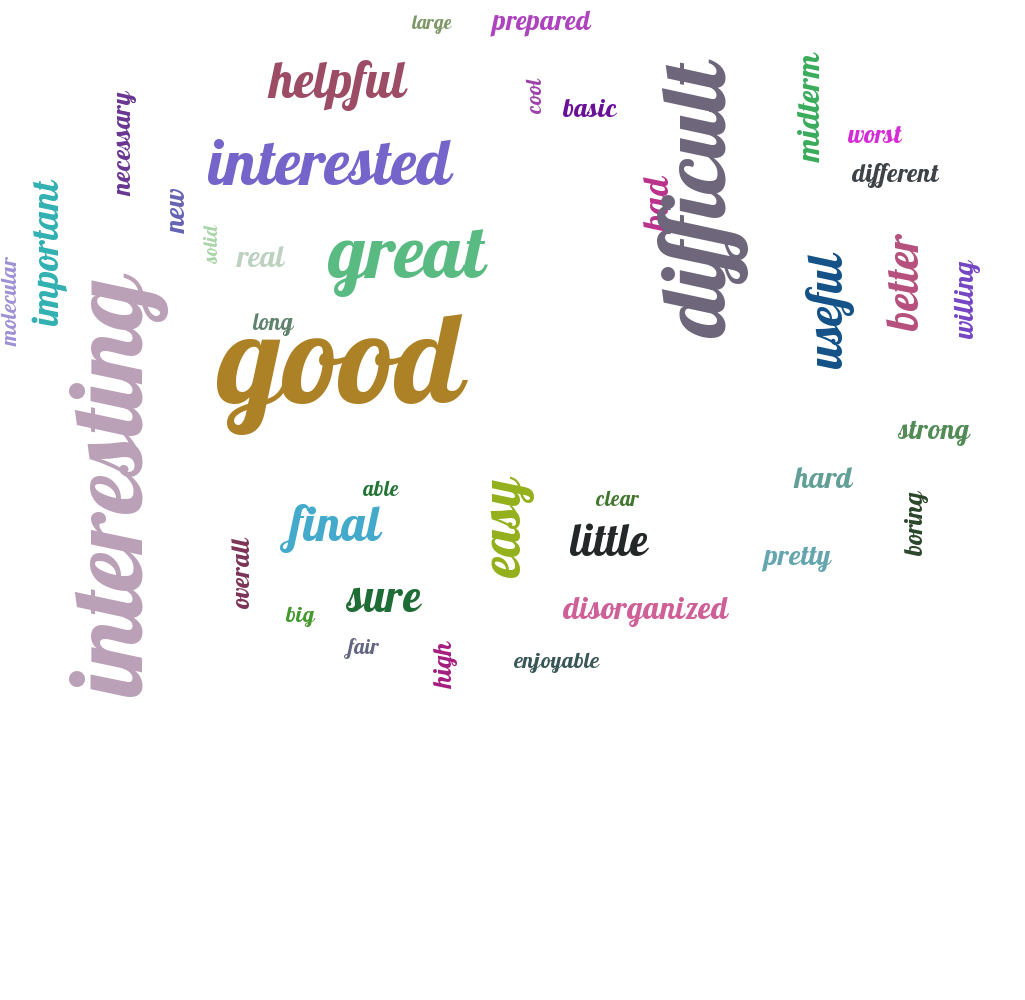

In [89]:
Image(filename='Top_20_Negative_A.png')

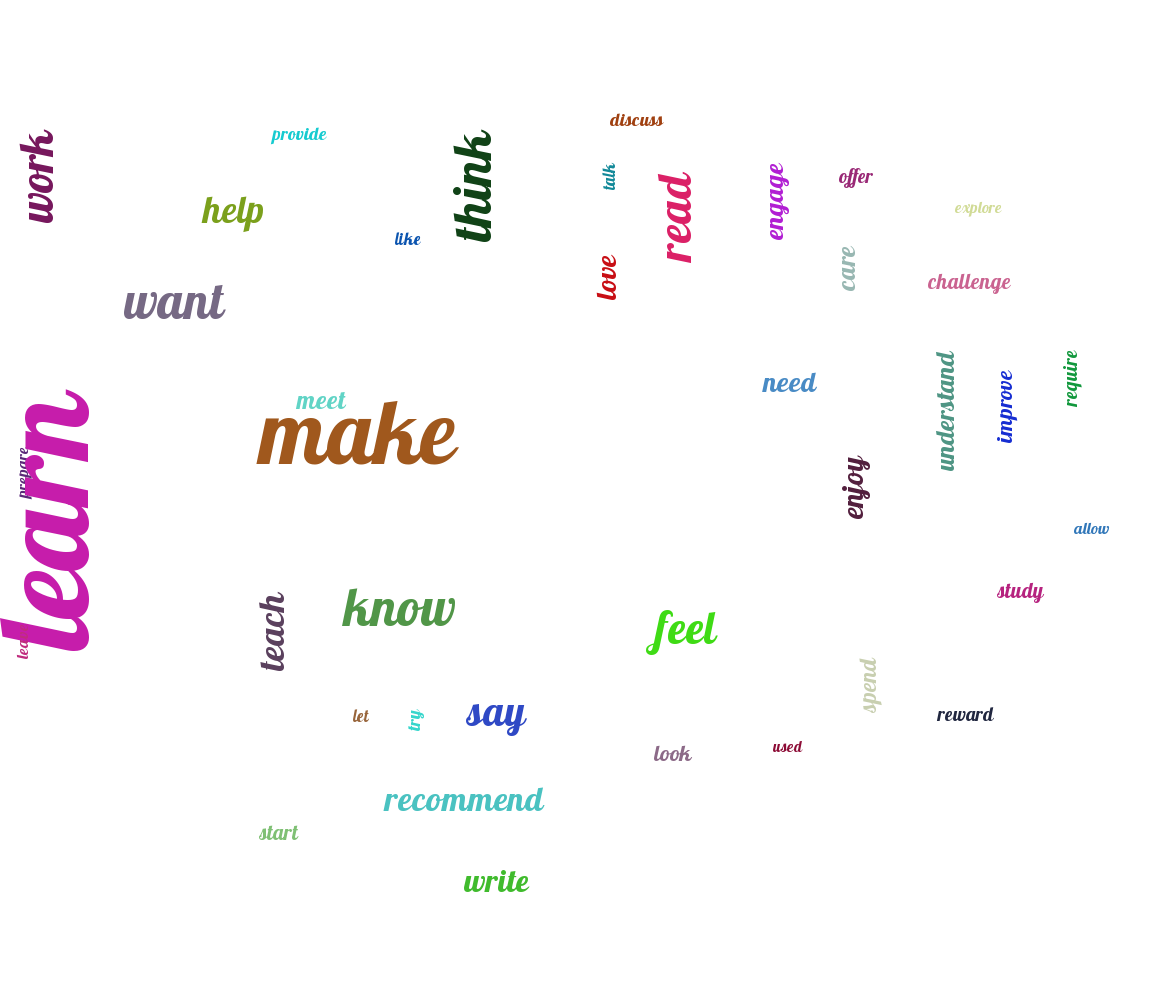

In [90]:
Image(filename='Top_20_Positive_V.png')

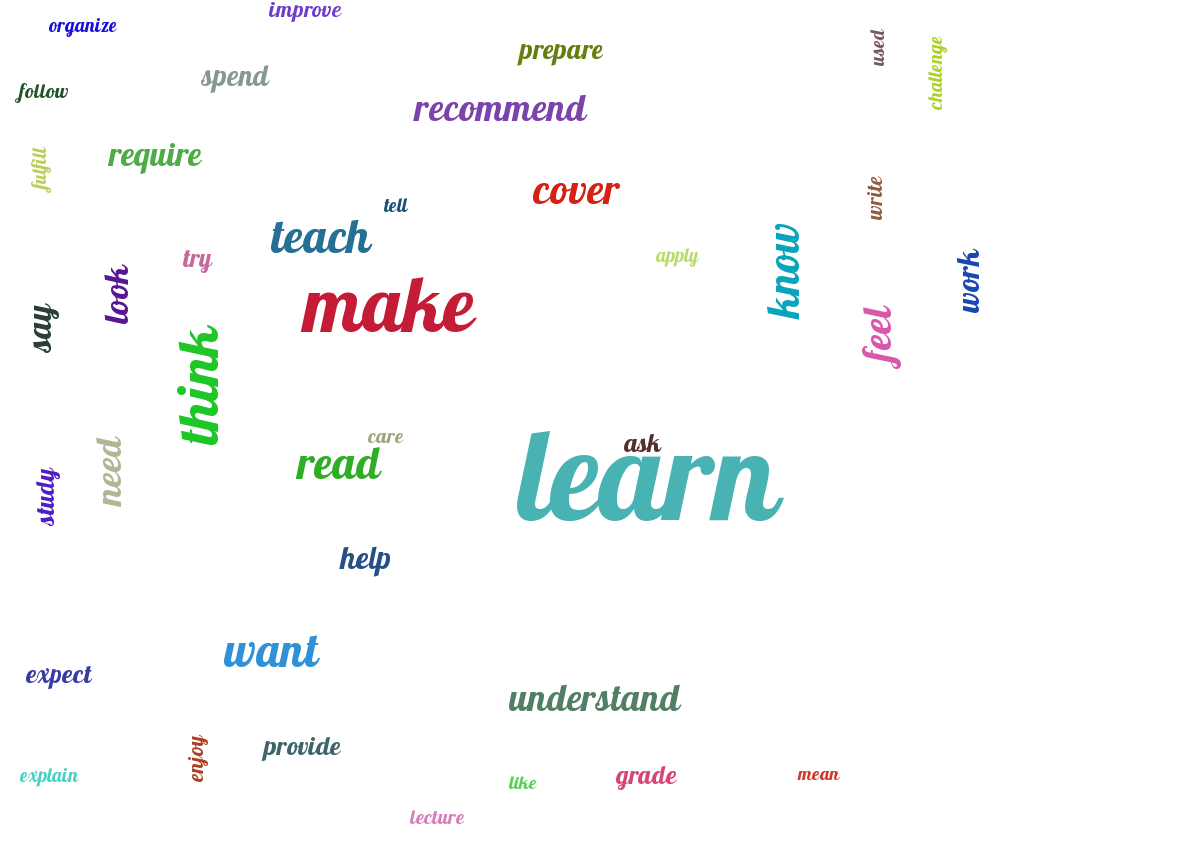

In [91]:
Image(filename='Top_20_Negative_V.png')